# eBOSS

### Imports

In [7]:
# some_file.py
import sys
import yaml
# insert at 1, 0 is the script path (or '' in REPL)

sys.path.insert(1, '/home/jaimerz/PhD/xCell')

from xcell.mappers import MappereBOSS
from xcell.mappers import utils
from xcell.cls.data import Data
from xcell.cls.cl import Cl
from xcell.cls.cov import Cov
from astropy.io import fits
from astropy.table import Table
import pyccl as ccl
import numpy as np
import pylab as plt
import pymaster as nmt
import healpy as hp
import numpy as np

### Configurations

In [8]:
ells = [0, 30, 60, 90, 120, 150, 180, 210, 240, 272, 309, 351, 398, 452, 513, 582, 661, 750, 852, 967, 1098, 1247, 1416, 1536] #1608, 1826, 2073, 2354, 2673, 3072]
bands = nmt.NmtBin.from_edges(ells[:-1], ells[1:])
ell_arr = bands.get_effective_ells()

In [9]:
bands = nmt.NmtBin.from_edges(ells[:-1], ells[1:])
ell_arr = bands.get_effective_ells()

In [10]:
data = Data(data_path="../config_files/master.yml")

In [11]:
QSO_0 = data.get_mapper("SDSS__QSO0")

In [12]:
QSO_0_map = QSO_0.get_signal_map()

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


Saving ../reruns/mask_mask_ELG_coordC_ns512.fits.gz
Saving ../reruns/SDSS_ELG_signal_map_coordC_ns512.fits.gz


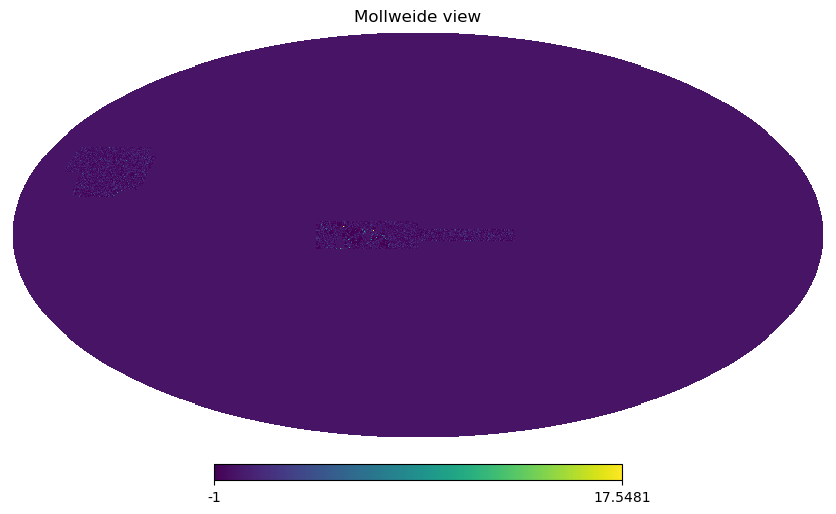

In [13]:
hp.visufunc.mollview(map=np.array(QSO_0_map)[0])

In [14]:
 cl = Cl(data.data, "SDSS__QSO0", "SDSS__QSO0")

/home/jaimerz/PhD/xCell/xcell/cls/data.py:416: UserWarning: A YML file was found in outdir: ../reruns/. Using it                  instead of input config.
  warn(f'A YML file was found in outdir: {outdir}. Using it \


In [15]:
cl.get_ell_cl()

Computing Cell for SDSS__QSO0 SDSS__QSO0
Reading ../reruns/SDSS_ELG_signal_map_coordC_ns512.fits.gz
Reading ../reruns/mask_mask_ELG_coordC_ns512.fits.gz
Saving ../reruns/SDSS_SDSS/w__mask_ELG__mask_ELG.fits
calculing nl from weights
Saving ../reruns/SDSS_ELG_Nell_coordC_ns512.npz
Saving ../reruns/SDSS_SDSS/cl_SDSS__QSO0_SDSS__QSO0.npz


(array([  14.5,   44.5,   74.5,  104.5,  134.5,  164.5,  194.5,  224.5,
         255.5,  290. ,  329.5,  374. ,  424.5,  482. ,  547. ,  621. ,
         705. ,  800.5,  909. , 1032. , 1172. , 1331. , 1475.5]),
 array([[ 3.94196878e-06,  7.15062768e-06,  7.45231460e-06,
          4.58407044e-06,  2.66687472e-06,  1.74690350e-06,
          2.03706484e-06,  1.77149518e-06,  1.38926556e-06,
          6.83173894e-07,  7.60776881e-07,  5.60154116e-07,
          3.55008086e-07,  1.72316449e-07,  4.40121941e-07,
          5.88998983e-08,  4.48965036e-08,  1.18428528e-07,
          8.16366834e-08,  3.97422658e-08,  1.67462510e-08,
         -6.03024234e-08, -9.04490385e-08]]))

In [16]:
cov = Cov(data.data, "SDSS__QSO0", "SDSS__QSO0", "SDSS__QSO0", "SDSS__QSO0")

In [17]:
cov.get_covariance()

Get C_ells. It took 6.812413533528646e-05 min
Reading ../reruns/SDSS_SDSS/w__mask_ELG__mask_ELG.fits
Get workspaces. It took 7.009506225585937e-06 min
Reading ../reruns/SDSS_ELG_signal_map_coordC_ns512.fits.gz
Reading ../reruns/mask_mask_ELG_coordC_ns512.fits.gz
Saving ../reruns/cov/cw__mask_ELG__mask_ELG__mask_ELG__mask_ELG.fits
Get covariance workspace. It took 0.06988182862599691 min
Computed Gaussian covariance. It took 0.0001359105110168457 min
Added all covariances terms. It took 3.3775965372721356e-07 min
Saving ../reruns/cov/cov_SDSS__QSO0_SDSS__QSO0_SDSS__QSO0_SDSS__QSO0.npz
Saved cov npz file. It took 1.539786656697591e-05 min


array([[ 5.64261812e-12, -6.55495168e-13,  8.55378274e-17,
        -1.13666778e-14, -5.37897847e-15, -2.81871082e-15,
        -8.11204365e-16, -8.47148099e-16, -3.04923128e-16,
        -4.01581332e-16, -4.73022762e-16, -1.50011962e-16,
        -1.21625574e-16, -1.48636360e-16, -6.39468791e-17,
        -4.86017872e-17, -4.17195349e-17, -2.36356733e-17,
        -1.73873496e-17, -1.18429804e-17, -7.81456546e-18,
        -7.27882926e-18, -6.15881412e-18],
       [-6.55495168e-13,  3.39945337e-12, -4.63084342e-13,
         3.15120492e-15, -1.06575694e-14, -5.67095592e-15,
        -3.25813206e-15, -1.10499792e-15, -1.12162861e-15,
        -9.30257380e-16, -7.06591941e-16, -5.04694122e-16,
        -2.87033719e-16, -2.85762895e-16, -1.73340371e-16,
        -1.22837460e-16, -9.65248318e-17, -6.16602042e-17,
        -4.63754318e-17, -3.58075850e-17, -2.72993721e-17,
        -2.60243763e-17, -2.16831105e-17],
       [ 8.55378274e-17, -4.63084342e-13,  2.04493686e-12,
        -2.26296035e-13,  1.8

In [18]:
""" fhdhfddah fd

SyntaxError: EOF while scanning triple-quoted string literal (3917757776.py, line 1)

In [ ]:
with open("../config_files/eBOSS/QSO_0.yml", 'r') as stream:
    config_QSO_0 = yaml.safe_load(stream)

with open("../config_files/eBOSS/QSO_1.yml", 'r') as stream:
    config_QSO_1 = yaml.safe_load(stream)

with open("../config_files/eBOSS/ELG.yml", 'r') as stream:
    config_ELG = yaml.safe_load(stream)

with open("../config_files/eBOSS/LRG.yml", 'r') as stream:
    config_LRG = yaml.safe_load(stream)

### Create maps

In [ ]:
QSO_0 = MappereBOSS(data)

In [ ]:
data

In [ ]:
QSO_0 = MappereBOSS(data)
QSO_1 = MappereBOSS(config_QSO_1)
ELG = MappereBOSS(config_ELG)
LRG = MappereBOSS(config_LRG)

In [ ]:
#ELG_map = ELG.get_signal_map()
#LRG_map = LRG.get_signal_map()
QSO_0_map = QSO_0.get_signal_map()
#QSO_1_map =QSO_1.get_signal_map()

In [ ]:
hp.visufunc.mollview(map=np.array(QSO_0_map)[0])

In [ ]:
hp.visufunc.mollview(map=np.array(QSO_1_map)[0])

In [ ]:
hp.visufunc.mollview(map=np.array(ELG_map)[0])

In [ ]:
hp.visufunc.mollview(map=np.array(LRG_map)[0])

### Cl's

In [ ]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)
#ELG: 𝑏SGC = 1.310 ± 0.020 , 𝑏NGC = 1.330 ± 0.020 https://arxiv.org/pdf/2007.09012.pdf
b_QSO_0 = config_QSO_0["bias"]*np.ones(config_QSO_0["num_z_bins"])
b_QSO_1 = config_QSO_1["bias"]*np.ones(config_QSO_1["num_z_bins"]) 
b_ELG = config_ELG["bias"]*np.ones(config_ELG["num_z_bins"]) # https://arxiv.org/abs/1509.05045
b_LRG = config_LRG["bias"]*np.ones(config_LRG["num_z_bins"]) # https://arxiv.org/pdf/1607.05383.pdf

In [ ]:
QSO_0_nz = QSO_0.get_nz()
QSO_1_nz = QSO_1.get_nz()
LRG_nz = LRG.get_nz()
ELG_nz = ELG.get_nz()

QSO_0_z = QSO_0_nz[0]
QSO_0_dNdz = QSO_0_nz[1]
QSO_1_z = QSO_1_nz[0]
QSO_1_dNdz = QSO_1_nz[1]
LRG_z = LRG_nz[0]
LRG_dNdz = LRG_nz[1]
ELG_z = ELG_nz[0]
ELG_dNdz = ELG_nz[1]

In [ ]:
QSOt_0 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(QSO_0_z, QSO_0_dNdz), bias=(QSO_0_z, b_QSO_0))
QSOt_1 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(QSO_1_z, QSO_1_dNdz), bias=(QSO_1_z, b_QSO_1))
ELGt = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(ELG_z, ELG_dNdz), bias=(ELG_z, b_ELG))
LRGt = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(LRG_z, LRG_dNdz), bias=(LRG_z, b_LRG))

In [ ]:
plt.plot(ELG_z, ELG_dNdz, label='ELG')
plt.plot(LRG_z, LRG_dNdz, label='LRG')
plt.plot(QSO_0_z, QSO_0_dNdz, label='QSO_0')
plt.plot(QSO_1_z, QSO_1_dNdz, label='QSO_1')
plt.legend()
plt.show()

In [ ]:
QSOt_cl_00 = ccl.angular_cl(cosmo, QSOt_0, QSOt_0, ell_arr) 
QSOt_cl_11 = ccl.angular_cl(cosmo, QSOt_1, QSOt_1, ell_arr) 
ELGt_cl = ccl.angular_cl(cosmo, ELGt, ELGt, ell_arr) 
LRGt_cl = ccl.angular_cl(cosmo, LRGt, LRGt, ell_arr) 

In [ ]:
QSO_f_0 =  QSO_0.get_nmt_field()
QSO_f_1 =  QSO_1.get_nmt_field()

In [ ]:
ELG_f =  ELG.get_nmt_field()
LRG_f =  LRG.get_nmt_field()

In [ ]:
QSO_w_00 = nmt.NmtWorkspace()
QSO_w_00.compute_coupling_matrix(QSO_f_0, QSO_f_0, bands)

QSO_w_11 = nmt.NmtWorkspace()
QSO_w_11.compute_coupling_matrix(QSO_f_1, QSO_f_1, bands)

In [ ]:
ELG_w = nmt.NmtWorkspace()
ELG_w.compute_coupling_matrix(ELG_f, ELG_f, bands)

LRG_w = nmt.NmtWorkspace()
LRG_w.compute_coupling_matrix(LRG_f, LRG_f, bands)

In [ ]:
QSO_cl_c_00 = nmt.compute_coupled_cell(QSO_f_0, QSO_f_0)
QSO_cl_c_11 = nmt.compute_coupled_cell(QSO_f_1, QSO_f_1)
ELG_cl_c = nmt.compute_coupled_cell(ELG_f, ELG_f)
LRG_cl_c = nmt.compute_coupled_cell(LRG_f, LRG_f)

In [ ]:
QSO_cl_00 = QSO_w_00.decouple_cell(QSO_cl_c_00)
QSO_cl_11 = QSO_w_11.decouple_cell(QSO_cl_c_11)
ELG_cl = ELG_w.decouple_cell(ELG_cl_c)
LRG_cl = LRG_w.decouple_cell(LRG_cl_c)

In [ ]:
QSO_nl_c_00 = QSO_0.get_nl_coupled() 
QSO_nl_c_11 = QSO_1.get_nl_coupled() 
ELG_nl_c = ELG.get_nl_coupled() 
LRG_nl_c = LRG.get_nl_coupled() 

In [ ]:
QSO_nl_00 = QSO_w_00.decouple_cell(QSO_nl_c_00)
QSO_nl_11 = QSO_w_11.decouple_cell(QSO_nl_c_11)
ELG_nl = ELG_w.decouple_cell(ELG_nl_c)
LRG_nl = LRG_w.decouple_cell(LRG_nl_c)

In [ ]:
plt.plot(ell_arr, QSO_cl_00[0]-QSO_nl_00[0], 'o-', label='data')
plt.plot(ell_arr, QSOt_cl_00, 'o-', label='theory')
plt.title('Quasars density angular NGC 00')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.xscale("log")
plt.yscale("log")
plt.show()

In [ ]:
plt.plot(QSO_cl_11[0]-QSO_nl_11[0], 'o-', label='data')
plt.plot(QSOt_cl_11, 'o-', label='theory')
plt.title('Quasars density angular NGC 11')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.xscale("log")
plt.yscale("log")
plt.show()

In [ ]:
plt.plot(ell_arr, LRG_cl[0]-LRG_nl[0], 'o-', label='data')
plt.plot(ell_arr, LRGt_cl, 'o-', label='theory')
plt.title('LRG density angular')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
plt.plot(ell_arr, ELG_cl[0]-ELG_nl[0], 'o-', label='data')
plt.plot(ell_arr, ELGt_cl, 'o-', label='theory')
plt.title('ELG density angular')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.xscale('log')
plt.yscale('log')
plt.show()